# <u>M</u>edical <u>D</u>eep <u>L</u>earning
## Exercise 2: ECG Sequence Classification



![Smartwatch](https://cloud.imi.uni-luebeck.de/s/qC5r57esfid7fSx/download)

![ECG Video](https://cloud.imi.uni-luebeck.de/s/QzGB78za3s5fJZM/download)

The goal of this exercise is to classify (variable-length) ECG recordings of the PhysioNet/CinC Challenge into four rythm classes: normal sinus rhythms (N), atrial fibrillation (AF), other rhythms (O), noise signals (∼).

Download the needed files `mdl_exercise1.ipynb`, `mdl_exercise1_utils.py` and `featnet1.pt` automatically.

In [ ]:
!wget -nc https://cloud.imi.uni-luebeck.de/s/SGZiDPjny7Si6cS/download -O mdl_exercise2_utils.py
!wget -nc https://cloud.imi.uni-luebeck.de/s/2qnRpqx9SmdwLCR/download -O featnet1.pt
!wget -nc https://cloud.imi.uni-luebeck.de/s/B7myD39xfjMCjnS/download -O FeatNet1.py

File ‘mdl_exercise2_utils.py’ already there; not retrieving.
File ‘featnet1.pt’ already there; not retrieving.
File ‘FeatNet1.py’ already there; not retrieving.


In [ ]:
!pip install wget
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

import mdl_exercise2_utils as mdl_e1_utils
from FeatNet1 import FeatNet1, ResBlock

# settings
%matplotlib inline
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

100% [..............................................................................] 76752 / 76752

## Task 1: PhysioNet/CinC Challenge

Inspect the challenge data. In the following cell the physionet dataset is loaded and relevant dataset information is printed as well as exemplary ECG rhythms are plotted.

First we get the raw data and their corresponding labels as a list of dicts (keys: input, target). We extract the ground truth/labels and save them in the tensor `labels`. To keep the labels in a human-readable way, we also create a mapping `label_map`.

In [ ]:
records_and_labels, sample_rate = mdl_e1_utils.get_physionet_dataset()
labels = torch.tensor([e['target'] for e in records_and_labels])
label_map = ['N', 'AF', 'O', '~']

Next, we want to extract some basic information about our dataset like the number of data its holding as well as the class distribution.

number of recordings:  8528
number of classes: 4


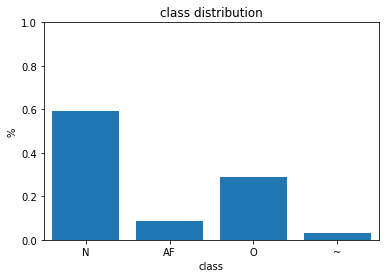

In [ ]:
# number of recordings
num_recordings = len(labels)
print('number of recordings: ', num_recordings)

# number of classes
num_classes = torch.unique(labels).numel()
print('number of classes:', num_classes)

# class distribution
class_distribution = torch.histc(labels.float(), bins=num_classes)/num_recordings
plt.figure('class distribution')
plt.bar(torch.arange(num_classes), class_distribution)
plt.title('class distribution')
plt.xlabel('class')
plt.xticks(ticks=torch.arange(num_classes), labels=label_map)
plt.xlim([-0.5, num_classes-0.5])
plt.ylabel('%')
plt.ylim([0, 1]);

Let's plot an example for every of our four ECG types.

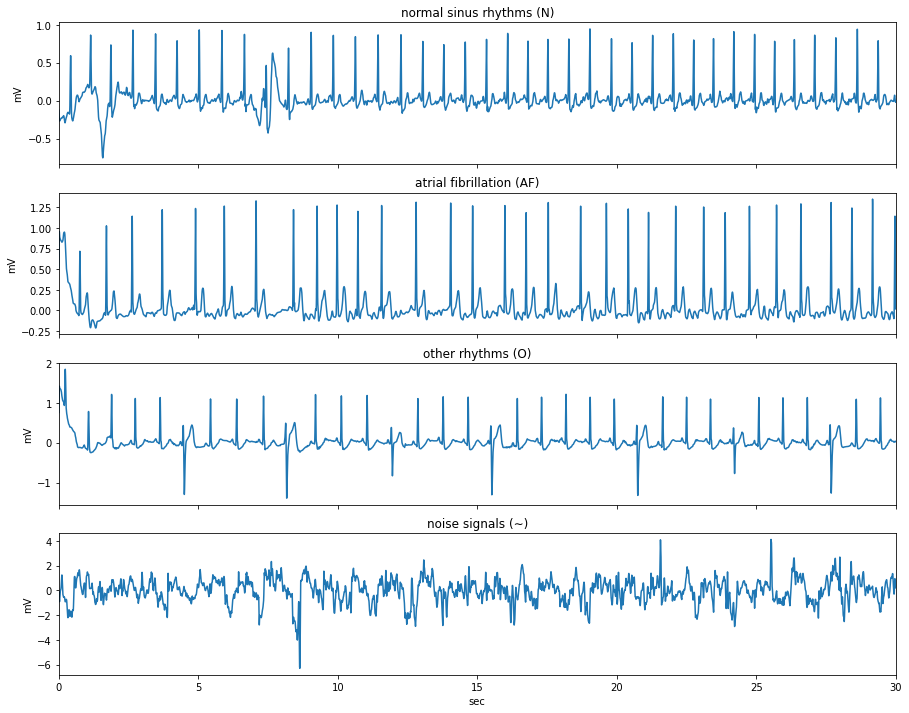

In [ ]:
# plot signals (one example for each target)
fig, axs = plt.subplots(num_classes, 1, sharex=True, figsize=(15,3*num_classes))
index = [0, 3, 76, 1245]
long_label_mapping = ['normal sinus rhythms (N)', 'atrial fibrillation (AF)', 'other rhythms (O)', 'noise signals (∼)']

for i in range(num_classes):
    signal = records_and_labels[index[i]]['input']
    axs[i].plot((torch.arange(signal.numel()).float()/sample_rate).numpy(), (signal/1000).numpy())
    axs[i].set_title(long_label_mapping[i])
    axs[i].set_xlim([0, 30])
    axs[i].set_ylabel('mV')
axs[i].set_xlabel('sec');

The last information, we want to extract, is the distribution of the signal length.

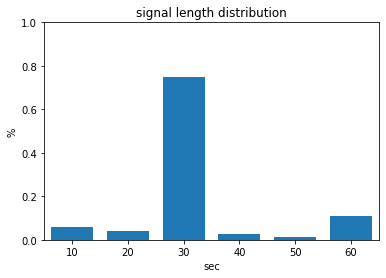

In [ ]:
# signal length distribution
signal_length_distribution = torch.histc(torch.tensor([entry['input'].numel()/sample_rate for entry in records_and_labels]), bins=6)/num_recordings
plt.figure('signal length distribution')
plt.bar((torch.arange(6)+1)*10, signal_length_distribution, width=7.5)
plt.title('signal length distribution')
plt.xlabel('sec')
plt.xticks((torch.arange(6)+1)*10)
plt.xlim([5, 65])
plt.ylabel('%')
plt.ylim([0, 1]);

## Task 2: Preprocessing

As you saw in the previous cell, the recordings in the dataset are not normalized and of variable sequence length.

To use the ecg signals with our neural nets normalize each recording $s$ to have *zero mean* and *unit variance*.
$$
s'=\frac{s-\mu_s}{\sigma_s}
$$
where $\mu_s$ and $\sigma_s$ are the mean and standard deviation calculated over each record in the dataset. Iterate over the dataset to calculate $\mu$ and $\sigma$ for each record and normalize it.

In [ ]:
# normalize each recording
for i in range(num_recordings):
    # load
    signal = records_and_labels[i]['input']
    
    mean = torch.mean(signal)
    std = torch.std(signal)
    signal = (signal - mean)/std
    
    # save
    records_and_labels[i]['input'] = signal

To make the handling of the data easier, we want to ensure, that all signals have the **same length of 30 seconds**. To do that, iterate over the data:
* if a recording is longer than 30 seconds crop it symmetrically
* if it is shorter pad the signal with zeros using `F.pad` ([pytorch-doc](https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html)), again symmetrically.

To obtain the length of the signal in seconds, divide its length/number of elements with the `sample_rate` in Hz (it is the same for all recordings). The cropped or padded signal should then append to the list `data`.

In [ ]:
# to fixed signal length
fixed_signal_length = 30
import numpy as np
for i in range(num_recordings):
    # load
    signal = records_and_labels[i]['input']
    
    # todo
    if (len(signal)/sample_rate) > fixed_signal_length: 
      mid = int(len(signal)/2)
      signal = signal[(mid-4500):(mid+4500)]
    else:
      padding = (fixed_signal_length - len(signal)/sample_rate)*sample_rate
      padding_left = int(np.ceil(padding // 2))
      padding_right = int(np.ceil(padding - padding_left))
      signal = F.pad(signal, (padding_left,padding_right))
      mid = int(len(signal)/2)
      signal = signal[(mid-4500):(mid+4500)]

    # save
    records_and_labels[i]['input'] = signal

As you can remember from the class distribution plot, the classes $\omega$ are unbalanced. So we create class weights $w_\omega$ to weight the loss during training. We obtain them with the formula of the **root inverse frequency**:
$$ w_{\omega_i} = \sqrt{(P_{\omega_i})^{-1}}$$
We calculate $P_{\omega_i}$ by counting the labels with `torch.bincount` and dividing them by `num_recordings`. The first element of the weight tensor should contain $1.2995$.

In [ ]:
P = torch.bincount((labels).to(torch.long)).to(torch.float)/num_recordings # todo
class_weights = torch.pow(P, -0.5) # todo
class_weights

tensor([1.2995, 3.3993, 1.8634, 5.4798])

Next, we prepare all data in datasets for training and validation. In this exercise we perform a single fold validation on a fixed train/valid set (with ratio 90:10).

In [ ]:
# provided dataset class
class CinCDataset(Dataset):
    def __init__(self, data: torch.Tensor, ground_truth: torch.Tensor):
        super().__init__()
        self.data = data.unsqueeze(1)
        self.ground_truth = ground_truth
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.ground_truth[idx]

# for reproducibility (do not change)
torch.manual_seed(0)

# split dataset in train/valid set
ratio = 0.9
split = int(num_recordings*ratio)
perm = torch.randperm(num_recordings)

dataset_train = [records_and_labels[i] for i in perm[:split]]
dataset_valid = [records_and_labels[i] for i in perm[split:]]

input_train = torch.stack([entry['input'] for entry in dataset_train])
target_train = torch.cat([entry['target'] for entry in dataset_train])
input_valid = torch.stack([entry['input'] for entry in dataset_valid])
target_valid = torch.cat([entry['target'] for entry in dataset_valid])

# create dataloader for training
train_dataset = CinCDataset(input_train, target_train)
val_dataset = CinCDataset(input_valid, target_valid)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, drop_last=False)

## Task 3 (5 points): 7 Layer ResNet + Linear Classifier
Load the pretrained 7 layer ResNet (featnet1.pt) with `torch.load()` and implement a linear classifier with `nn.Linear()` for the ecg classification task (4 classes). Use `nn.AdaptiveMaxPool1d()` to reduce the temporal dimension after the feature extraction to 1 (feature dimension is 64).

In [ ]:
# classifier1
class Classifier1(nn.Module):
    def __init__(self):
        super(Classifier1, self).__init__()
        
        self.featnet = torch.load("featnet1.pt") # todo
        self.pool = torch.nn.AdaptiveMaxPool1d(1) # todo
        self.classifier = torch.nn.Linear(64, 4) # todo
        
    def forward(self, x):
        
        x = self.featnet(x)
        x = self.pool(x)
        x = x.squeeze(2)
        x = self.classifier(x)
        
        return x

Check the number of trainable parameters of your model. You should obtain a total parameter count of approx. 171’000.

In [ ]:
from torchsummary import summary
summary(Classifier1().cuda(), (1, 30*sample_rate))

/home/sazid/.conda/envs/myenv/lib/python3.7/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/sazid/.conda/envs/myenv/lib/python3.7/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/sazid/.conda/envs/myenv/lib/python3.7/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm1d' has changed. you can retrieve the original

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 16, 9000]             288
       BatchNorm1d-2             [-1, 16, 9000]              32
              ReLU-3             [-1, 16, 9000]               0
            Conv1d-4             [-1, 32, 4500]             544
       BatchNorm1d-5             [-1, 32, 4500]              64
            Conv1d-6             [-1, 32, 4500]           8,736
       BatchNorm1d-7             [-1, 32, 4500]              64
              ReLU-8             [-1, 32, 4500]               0
            Conv1d-9             [-1, 32, 4500]          17,440
      BatchNorm1d-10             [-1, 32, 4500]              64
             ReLU-11             [-1, 32, 4500]               0
         ResBlock-12             [-1, 32, 4500]               0
           Conv1d-13             [-1, 32, 2250]           1,056
      BatchNorm1d-14             [-1, 3

Complete the training routine function `train` below. Apart from the model definitions set up an Adam optimizer with an initial learning rate of $0.001$, that receives the parameters for your model. During training, the learning rate should be exponentially decayed by a factor of 0.95. A cross entropy loss with root-inverse class weighting to encounter for the class-imbalance should be used as criterion for the parameter optimization.

Useful PyTorch functions: `optim.Adam(), optim.lr_scheduler.ExponentialLR(), nn.CrossEntropyLoss()`

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def train(model, num_epochs):
    # optimizer
    optimizer = torch.optim.Adam(list(model.parameters()), lr=0.001) # todo

    # learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95) # todo

    # criterion
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device)) # todo
    
    # for reproducibility (do not change)
    torch.manual_seed(0)
    
    # statistics
    losses_train = []
    f1s_train = []
    losses_valid = []
    f1s_valid = []

    # for num_epochs
    for epoch in trange(num_epochs, unit='epoch'):

        # train mode
        model.train()

        # statistics
        running_loss = 0.0
        conf_mat = torch.zeros(num_classes, num_classes).cuda()

        # for each mini-batch
        for input, target in train_dataloader:
            input = input.cuda()
            target = target.cuda()

            # zero the parameter gradients
            optimizer.zero_grad() # todo

            # forward + backward + optimize
            output = model(input) # todo
            loss = criterion(output, target) # todo
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item()
            conf_mat += mdl_e1_utils.confusion_mat(output, target)
            
        # update learning rate
        lr_scheduler.step()

        running_loss /= len(train_dataloader)
        f1 = mdl_e1_utils.f1_score(conf_mat)

        losses_train.append(running_loss)
        f1s_train.append(f1)

        # output
        tqdm.write('Epoch {} (train) -- loss: {:.4f} f1: {:.4f}'.format(epoch, running_loss, f1))

        # validate
        with torch.no_grad():

            # eval mode
            model.eval()

            # statistics
            running_loss = 0.0
            conf_mat = torch.zeros(num_classes, num_classes).cuda()

            # for each mini-batch
            for input, target in val_dataloader:
                input = input.cuda()
                target = target.cuda()

                # forward
                output = model(input)
                loss = criterion(output, target)

                # statistics
                running_loss += loss.item()
                conf_mat += mdl_e1_utils.confusion_mat(output, target)

            running_loss /= len(val_dataloader)
            f1 = mdl_e1_utils.f1_score(conf_mat)

            losses_valid.append(running_loss)
            f1s_valid.append(f1)

            # output
            tqdm.write('Epoch {} (valid) -- loss: {:.4f} f1: {:.4f}'.format(epoch, running_loss, f1))
    # make model callable outside this function
    train.trained_model = model

    # best F1 score
    print('Best F1 score (valid):', '{:.2f}'.format(round(max(f1s_valid), 2)))

Call the training function to train your `Classifier1` for 10 epochs. After training the best validation F1 score (averaged over classes N, AF and 0) should be around 0.76-0.77.

In [ ]:
model_1 = Classifier1().cuda()
train(model_1, 10) # todo

  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 0 (train) -- loss: 0.7451 f1: 0.6607
Epoch 0 (valid) -- loss: 0.6959 f1: 0.7181
Epoch 1 (train) -- loss: 0.5179 f1: 0.7691
Epoch 1 (valid) -- loss: 0.6247 f1: 0.7107
Epoch 2 (train) -- loss: 0.4288 f1: 0.8144
Epoch 2 (valid) -- loss: 0.6118 f1: 0.7245
Epoch 3 (train) -- loss: 0.3588 f1: 0.8483
Epoch 3 (valid) -- loss: 0.6367 f1: 0.7454
Epoch 4 (train) -- loss: 0.3086 f1: 0.8718
Epoch 4 (valid) -- loss: 0.6021 f1: 0.7403
Epoch 5 (train) -- loss: 0.2590 f1: 0.8965
Epoch 5 (valid) -- loss: 0.6992 f1: 0.7430
Epoch 6 (train) -- loss: 0.2125 f1: 0.9245
Epoch 6 (valid) -- loss: 0.6906 f1: 0.7245
Epoch 7 (train) -- loss: 0.1721 f1: 0.9428
Epoch 7 (valid) -- loss: 0.6844 f1: 0.7415
Epoch 8 (train) -- loss: 0.1323 f1: 0.9622
Epoch 8 (valid) -- loss: 0.7120 f1: 0.7509
Epoch 9 (train) -- loss: 0.1086 f1: 0.9723
Epoch 9 (valid) -- loss: 0.7432 f1: 0.7514
Best F1 score (valid): 0.75


## Task 4 (7 points): 15 Layer ResNet + Linear Classifier

Next, we want to even improve the performance by extending the `featnet` with some more ResNetBlocks. For the implementation follow the illustration using the appropriate torch functions.
![res block](https://cloud.imi.uni-luebeck.de/s/J4NTE8FT6PEiykr/download)

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ResNetBlock, self).__init__()
        
        # todo
        self.conv1d = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=2)
        self.bn1d = nn.BatchNorm1d(out_channels)

        self.conv1d_1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size//2, stride=2) # padding='same' is not supported for strided convolutions
        self.bn1d_1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.conv1d_2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.bn1d_2 = nn.BatchNorm1d(out_channels)


    def forward(self, x):
        
        # todo
        a = self.conv1d(x)
        a = self.bn1d(a)

        b = self.conv1d_1(x)
        b = self.bn1d_1(b)
        b = self.relu(b)
        b = self.conv1d_2(b)
        b = self.bn1d_2(b)

        x = a + b
        x = self.relu(x)
        
        return x

Employ a second ResNet (featnet2) that extends the featnet1 with 4 more ResNet blocks. The featnet2 starts with a ResNet block with 64 channels and doubles the channel number in every second block (starting at the first). The kernel size for every convolution is 17.

In [ ]:
class FeatNet2(nn.Module):
    def __init__(self):
        super(FeatNet2, self).__init__()

        self.ResBlock_1 = ResNetBlock(64, 64, 17)
        self.ResBlock_2 = ResNetBlock(64, 128, 17)
        self.ResBlock_3 = ResNetBlock(128, 128, 17)
        self.ResBlock_4 = ResNetBlock(128, 256, 17)

    def forward(self, x):
        
        # todo
        x = self.ResBlock_1(x)
        x = self.ResBlock_2(x)
        x = self.ResBlock_3(x)
        x = self.ResBlock_4(x)

        return x

Implement a linear classifier like in the previous task. It should hold both ResNets, the pretrained `featnet1` and the new one `featnet2`.

In [ ]:
class Classifier2(nn.Module):
    def __init__(self):
        super(Classifier2, self).__init__()
        
        self.featnet1 = torch.load("featnet1.pt") # todo
        self.featnet2 = FeatNet2() # todo
        self.pool = torch.nn.AdaptiveMaxPool1d(1) # todo
        self.classifier = torch.nn.Linear(256, 4) # todo
        
    def forward(self, x):
        
        # todo
        x = self.featnet1(x)
        x = self.featnet2(x)
        x = self.pool(x)
        x = x.squeeze(2)
        x = self.classifier(x)

        return x

Check the number of trainable parameters of your model. You should obtain a total parameter count of approx. 3’023’000.

In [ ]:
summary(Classifier2().cuda(), (1, 30*sample_rate))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 16, 9000]             288
       BatchNorm1d-2             [-1, 16, 9000]              32
              ReLU-3             [-1, 16, 9000]               0
            Conv1d-4             [-1, 32, 4500]             544
       BatchNorm1d-5             [-1, 32, 4500]              64
            Conv1d-6             [-1, 32, 4500]           8,736
       BatchNorm1d-7             [-1, 32, 4500]              64
              ReLU-8             [-1, 32, 4500]               0
            Conv1d-9             [-1, 32, 4500]          17,440
      BatchNorm1d-10             [-1, 32, 4500]              64
             ReLU-11             [-1, 32, 4500]               0
         ResBlock-12             [-1, 32, 4500]               0
           Conv1d-13             [-1, 32, 2250]           1,056
      BatchNorm1d-14             [-1, 3

Train both ResNet parts and the adapted linear classifier together for **15** epochs calling `train` on `Classifier2`. After training the best validation F1 score (averaged over classes N, AF and 0) should be around 0.81-0.82.

In [ ]:
# todo
model_2 = Classifier2().cuda()
train(model_2, 15)

  0%|          | 0/15 [00:00<?, ?epoch/s]

Epoch 0 (train) -- loss: 0.7784 f1: 0.6500
Epoch 0 (valid) -- loss: 0.7667 f1: 0.6725
Epoch 1 (train) -- loss: 0.5669 f1: 0.7640
Epoch 1 (valid) -- loss: 0.6907 f1: 0.6617
Epoch 2 (train) -- loss: 0.4733 f1: 0.8049
Epoch 2 (valid) -- loss: 0.4647 f1: 0.7866
Epoch 3 (train) -- loss: 0.4149 f1: 0.8254
Epoch 3 (valid) -- loss: 0.5281 f1: 0.8044
Epoch 4 (train) -- loss: 0.3704 f1: 0.8504
Epoch 4 (valid) -- loss: 0.4883 f1: 0.7969
Epoch 5 (train) -- loss: 0.3099 f1: 0.8731
Epoch 5 (valid) -- loss: 0.6276 f1: 0.7802
Epoch 6 (train) -- loss: 0.2423 f1: 0.9024
Epoch 6 (valid) -- loss: 0.5235 f1: 0.8030
Epoch 7 (train) -- loss: 0.1852 f1: 0.9325
Epoch 7 (valid) -- loss: 0.5882 f1: 0.7764
Epoch 8 (train) -- loss: 0.1393 f1: 0.9527
Epoch 8 (valid) -- loss: 0.5547 f1: 0.8088
Epoch 9 (train) -- loss: 0.0977 f1: 0.9645
Epoch 9 (valid) -- loss: 0.7827 f1: 0.7466
Epoch 10 (train) -- loss: 0.0622 f1: 0.9788
Epoch 10 (valid) -- loss: 0.7902 f1: 0.7856
Epoch 11 (train) -- loss: 0.0415 f1: 0.9886
Epoch 11

We save the trained ResNet in `conv_backbone` as convolutional backbone for the following task.

In [ ]:
conv_backbone = nn.Sequential(
    train.trained_model.featnet1,
    train.trained_model.featnet2,
)
summary(conv_backbone, (1, 30*sample_rate))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 16, 9000]             288
       BatchNorm1d-2             [-1, 16, 9000]              32
              ReLU-3             [-1, 16, 9000]               0
            Conv1d-4             [-1, 32, 4500]             544
       BatchNorm1d-5             [-1, 32, 4500]              64
            Conv1d-6             [-1, 32, 4500]           8,736
       BatchNorm1d-7             [-1, 32, 4500]              64
              ReLU-8             [-1, 32, 4500]               0
            Conv1d-9             [-1, 32, 4500]          17,440
      BatchNorm1d-10             [-1, 32, 4500]              64
             ReLU-11             [-1, 32, 4500]               0
         ResBlock-12             [-1, 32, 4500]               0
           Conv1d-13             [-1, 32, 2250]           1,056
      BatchNorm1d-14             [-1, 3

## Task 5: 15 Layer ResNet + LSTM + Linear Classifier

![lstm_img](https://cloud.imi.uni-luebeck.de/s/yX4yCexr9bL39cG/download)
Implement a **two-layer** LSTM (to follow the 15 layer ResNet stored in `conv_backbone`) with 64 output channels each. Therefore, use the `nn.LSTM` implementation. We use the `conv_backbone`'s last layer feature dimension as the `input_size` (remember pytorch's tensor structure of $[B, C, L]$) and 64 as `hidden_size`. With `batch_first=True` the LSTM expects the input to be of shape $[B, L, C]$, so transform the input to this in the `forward` function using `torch.transpose` first. The `output` of the LSTM contains the hidden state to every sequence entry, but we are only interested in the last one. Select this by indexing it and squeeze it, so the final output has a shape of $[B, 64]$.

In [ ]:
from torch.autograd import Variable
class LSTMNet(nn.Module):
    def __init__(self):
        super(LSTMNet, self).__init__()
        self.num_layers = 2
        self.input_size = 256
        self.hidden_size = 64
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        ula, (h_out, _) = self.lstm(x, (h0,c0))
        h_out = h_out[-1].view(-1, self.hidden_size)
        return h_out

Adapt the linear classifier (we do not need temporal pooling anymore) and add the `conv_backbone` and an instance of `LSTMNet`to it.

In [ ]:
class Classifier3(nn.Module):
    def __init__(self):
        super(Classifier3, self).__init__()
        self.conv_backbone = conv_backbone
        self.lstmNet = LSTMNet()
        self.classifier = torch.nn.Linear(64, 4)
        
    def forward(self, x):
        
        x = self.conv_backbone(x)
        x = self.lstmNet(x.permute(0, 2, 1))
        x = self.classifier(x)
        
        return x

In [ ]:
# I added to test it before training
# summary(Classifier3().cuda(), (1, 30*sample_rate))

Train it afterwards with the known training procedure for **15** epochs. After training the best validation F1 score (averaged over classes N, AF and 0) should be around 0.83-0.84.

In [ ]:
model_3 = Classifier3().cuda()
train(model_3, 15)

  0%|          | 0/15 [00:00<?, ?epoch/s]

Epoch 0 (train) -- loss: 0.7844 f1: 0.6326
Epoch 0 (valid) -- loss: 0.9074 f1: 0.5556
Epoch 1 (train) -- loss: 0.6470 f1: 0.7076
Epoch 1 (valid) -- loss: 0.6396 f1: 0.7094
Epoch 2 (train) -- loss: 0.5860 f1: 0.7498
Epoch 2 (valid) -- loss: 0.5375 f1: 0.7636
Epoch 3 (train) -- loss: 0.5371 f1: 0.7803
Epoch 3 (valid) -- loss: 0.5279 f1: 0.7802
Epoch 4 (train) -- loss: 0.5384 f1: 0.7824
Epoch 4 (valid) -- loss: 0.5469 f1: 0.7635
Epoch 5 (train) -- loss: 0.4849 f1: 0.7948
Epoch 5 (valid) -- loss: 0.4700 f1: 0.8060
Epoch 6 (train) -- loss: 0.4490 f1: 0.8217
Epoch 6 (valid) -- loss: 0.4644 f1: 0.8197
Epoch 7 (train) -- loss: 0.4453 f1: 0.8193
Epoch 7 (valid) -- loss: 0.4836 f1: 0.8055
Epoch 8 (train) -- loss: 0.3907 f1: 0.8443
Epoch 8 (valid) -- loss: 0.4434 f1: 0.7941
Epoch 9 (train) -- loss: 0.3786 f1: 0.8467
Epoch 9 (valid) -- loss: 0.4889 f1: 0.7960
Epoch 10 (train) -- loss: 0.3531 f1: 0.8535
Epoch 10 (valid) -- loss: 0.4654 f1: 0.8402
Epoch 11 (train) -- loss: 0.3464 f1: 0.8559
Epoch 11

## Bonus task (5 Points): Transformer

Another newer approach is the use of so-called transformer, that relay on self-attention mechanism (see [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf)) instead on deep, pretrained CNNs for the feature extraction. We only need a very lightweight convolutional backbone here consisting of two CBR-Blocks (`nn.Conv1d`, `nn.Batchnorm1d`, `nn.Leaky`). Both have `kernel_size=17` and `stride=12`. The first block increase the channel_dimension to 32 and the second one double it to 64.

For the transformer, we need to call an instance of `nn.TransformerEncoder` with `num_layers = 6`. As a layer we use `nn.TransformerEncoderLayer` with `nhead=4, dim_feedforward=512` and `batch_first=True`. Fit `d_model` to the number of feature extracted by the convolutional backbone.  As classifier, we just use a `nn.Linear`again that divide the feature space into the class decision regions. Implement the `forward` analog to the LSTM-task, but instead of using the last entry  of the output sequence as input for our linear classifier, we calculate the mean over its sequence dimension $L$.

In [ ]:
conv_backbone = nn.Sequential(
    # 1st layer group
    nn.Conv1d(in_channels=1, out_channels=32, kernel_size=17, stride=12),
    nn.BatchNorm1d(32),
    nn.LeakyReLU(), # there is no nn.Leaky()
    # 2nd layer group
    nn.Conv1d(in_channels=32, out_channels=64, kernel_size=17, stride=12),
    nn.BatchNorm1d(64),
    nn.LeakyReLU()
)

In [ ]:
summary(conv_backbone.cuda(), (1, 30*sample_rate))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 749]             576
       BatchNorm1d-2              [-1, 32, 749]              64
         LeakyReLU-3              [-1, 32, 749]               0
            Conv1d-4               [-1, 64, 62]          34,880
       BatchNorm1d-5               [-1, 64, 62]             128
         LeakyReLU-6               [-1, 64, 62]               0
Total params: 35,648
Trainable params: 35,648
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.64
Params size (MB): 0.14
Estimated Total Size (MB): 0.81
----------------------------------------------------------------


In [ ]:
class TransformerClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        feat_dim = 64
        
        self.conv_backbone = conv_backbone # todo
        encoder_layer = nn.TransformerEncoderLayer(d_model=64, nhead=4, dim_feedforward=512, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=6) # todo
        self.classifier = nn.Linear(64, 4) # todo
        
    def forward(self, x):
        # todo
        x = self.conv_backbone(x)
        x = self.transformer(x.permute(0, 2, 1))
        x = torch.mean(x, dim=1)
        x = self.classifier(x)

        return x

Train the transformer classifier with the given training procedure for **20** epochs. Use the same optimizer and criterion (do not forget the `class_weights`) like in the other trainings. After training the best validation F1 score (averaged over classes N, AF and 0) should be around 0.65. For comparison: two LSTM cells in the same setting would only reach a f1 of 0.51.

In [ ]:
model = TransformerClassifier().cuda()

# parameters
batch_size = 32
init_lr = .0001
num_epochs = 20
# optimizer
optimizer = torch.optim.Adam(list(model.parameters()), lr=init_lr) # todo

# criterion
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device)) # todo

torch.manual_seed(0)


# statistics
losses_train = []
f1s_train = []
losses_valid = []
f1s_valid = []
import time
t0 = time.time()

# for num_epochs
for epoch in range(num_epochs):

    # train mode
    model.train()

    # random mini-batches
    batch_train = torch.randperm(len(dataset_train))
    batch_train = batch_train[(batch_train.numel() % batch_size):]
    batch_train = batch_train.view(-1, batch_size)

    # statistics
    running_loss = 0.0
    conf_mat = torch.zeros(num_classes, num_classes).cuda()

    # for each mini-batch
    for i in range(batch_train.size(0)):

        # mini-batch
        R_st = int(torch.randint(32,(1,)))
        input = input_train[batch_train[i], R_st+32:R_st-32].unsqueeze(1).cuda()
        target = target_train[batch_train[i]].cuda()

        # zero the parameter gradients
        optimizer.zero_grad() # todo

        # forward + backward + optimize
        output = model(input) # todo
        loss = criterion(output, target) # todo
        loss.backward()
        optimizer.step()


        # statistics
        running_loss += loss.item()
        conf_mat += mdl_e1_utils.confusion_mat(output, target)

    running_loss /= batch_train.size(0)
    f1 = mdl_e1_utils.f1_score(conf_mat)

    losses_train.append(running_loss)
    f1s_train.append(f1)

    # output
    print('Epoch {} (train) -- loss: {:.4f} f1: {:.4f}, time {:.2f} s'.format(epoch, running_loss, f1,time.time()-t0))

    # validate
    with torch.no_grad():

        # eval mode
        model.eval()

        # random mini-batches
        batch_valid = torch.randperm(len(dataset_valid))
        batch_valid = batch_valid[(batch_valid.numel() % batch_size):]
        batch_valid = batch_valid.view(-1, batch_size)

        # statistics
        running_loss = 0.0
        conf_mat = torch.zeros(num_classes, num_classes).cuda()

        # for each mini-batch
        for i in range(batch_valid.size(0)):

            # mini-batch
            input = input_valid[batch_valid[i], :].unsqueeze(1).cuda()

            target = target_valid[batch_valid[i]].cuda()

            # forward
            output = model(input)


            #output = torch.argmax(output,1)
            loss = criterion(output, target)

            # statistics
            running_loss += loss.item()
            conf_mat += mdl_e1_utils.confusion_mat(output, target)

        running_loss /= batch_valid.size(0)
        f1 = mdl_e1_utils.f1_score(conf_mat)

        losses_valid.append(running_loss)
        f1s_valid.append(f1)

        # output
        print('Epoch {} (valid) -- loss: {:.4f} f1: {:.4f}'.format(epoch, running_loss, f1))

Epoch 0 (train) -- loss: 1.1202 f1: 0.4004, time 5.92 s
Epoch 0 (valid) -- loss: 0.9860 f1: 0.5150
Epoch 1 (train) -- loss: 0.9842 f1: 0.5023, time 11.96 s
Epoch 1 (valid) -- loss: 0.8680 f1: 0.5374
Epoch 2 (train) -- loss: 0.9099 f1: 0.5413, time 16.89 s
Epoch 2 (valid) -- loss: 0.8357 f1: 0.5481
Epoch 3 (train) -- loss: 0.8634 f1: 0.5608, time 25.46 s
Epoch 3 (valid) -- loss: 0.8261 f1: 0.5405
Epoch 4 (train) -- loss: 0.8398 f1: 0.5779, time 32.28 s
Epoch 4 (valid) -- loss: 0.8283 f1: 0.5690
Epoch 5 (train) -- loss: 0.8113 f1: 0.6060, time 41.01 s
Epoch 5 (valid) -- loss: 0.8140 f1: 0.5948
Epoch 6 (train) -- loss: 0.7888 f1: 0.6116, time 46.47 s
Epoch 6 (valid) -- loss: 0.7662 f1: 0.6185
Epoch 7 (train) -- loss: 0.7621 f1: 0.6280, time 52.37 s
Epoch 7 (valid) -- loss: 0.7320 f1: 0.6248
Epoch 8 (train) -- loss: 0.7473 f1: 0.6294, time 59.32 s
Epoch 8 (valid) -- loss: 0.7372 f1: 0.5680
Epoch 9 (train) -- loss: 0.7408 f1: 0.6322, time 64.02 s
Epoch 9 (valid) -- loss: 0.7069 f1: 0.6246
E

In [ ]:
    # best F1 score
    print('Best F1 score (valid):', '{:.2f}'.format(round(max(f1s_valid), 2)))